In [2]:
import tempfile

from drawthis.core.models.session.dataclasses import ImageRow
from drawthis.persistence.session.sqlite3_backend import SQLite3Backend

### **Benchmark Goal**
Determine the optimal commit batch size for the default SQLite 3 backend when used with the filesystem crawler.

### Procedure
1. **Create a temporary on‑disk directory** that will hold the SQLite database.
2. **Initialize the database** before running any benchmarks to ensure a consistent starting state.
3. **Run each batch size** `N` = **5 times** and record the median result.

### Test Setup
- **Directory size:** 100 k files, with arbitrary depth and breadth.
- **Batch sizes to test:** `1, 10, 100, 500, 1 000, 2 500, 5 000, 10 000, 20 000, 30 000, 40 000, 50 000`.

### Expected Outcomes
- **Speed‑memory trade‑off:** Optimal range expected between **1000–5000 rows per commit**.
- **Throughput:** ≥ 50 k files / second.
- **Peak memory usage:** ≤ 8 MB.


### Preparing fixtures

In [21]:
from typing import Generator

tempfile.mktemp()

batch_sizes = [1, 10, 100, 500, 1_000, 2_500, 5_000, 10_000, 20000, 30000, 40000, 50000]
num_files = 100_000
runs = 5

def fake_crawl(number_files=100_000):
    for i in range(number_files):
        yield ImageRow(file_path=f"/fake/dir/{i:06d}.png", randid=i, mtime=i)

def generator_of_batches(rows: Generator[ImageRow, None, None], batch_size: int) -> Generator[Generator[ImageRow, None, None], None, None]:
    """
    Yield generators of up to batch_size rows.
    Each batch is itself a generator, not a list.
    """
    def make_batch(
        initial_row: ImageRow,
        remaining_rows: Generator[ImageRow, None, None],
    ):
        """Yield first_row + up to batch_size-1 from remaining_rows"""
        count = 0
        yield initial_row
        count += 1
        for row in remaining_rows:
            yield row
            count += 1
            if count >= batch_size:
                break

    # Materialize the rows_generator as an iterator
    rows_iter = iter(rows)
    while True:
        try:
            first_row = next(rows_iter)
        except StopIteration:
            break
        # Yields mini generators of size: batch_size
        yield make_batch(first_row, rows_iter)

### SQLite 3 commit assesment

In [22]:
import statistics, time, tracemalloc, tempfile
from pathlib import Path

results = []

for bs in batch_sizes:
    timings = []
    for _ in range(runs):
        with tempfile.TemporaryDirectory(prefix="bench_db_") as tmpdir:
            db_path = Path(tmpdir) / "benchmark.db"
            crawler = fake_crawl(num_files)
            batches = generator_of_batches(crawler, batch_size=bs)
            backend = SQLite3Backend(db_path=db_path)

            tracemalloc.start()
            start = time.perf_counter()

            for batch in batches:
                inserted = backend.insert_rows(batch)

            backend.commit()

            end = time.perf_counter()
            _, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()

        timings.append((end - start, peak))
    median_time, median_mem = statistics.median(t[0] for t in timings), statistics.median(t[1] for t in timings)
    results.append((bs, median_time, median_mem))

### Visualization

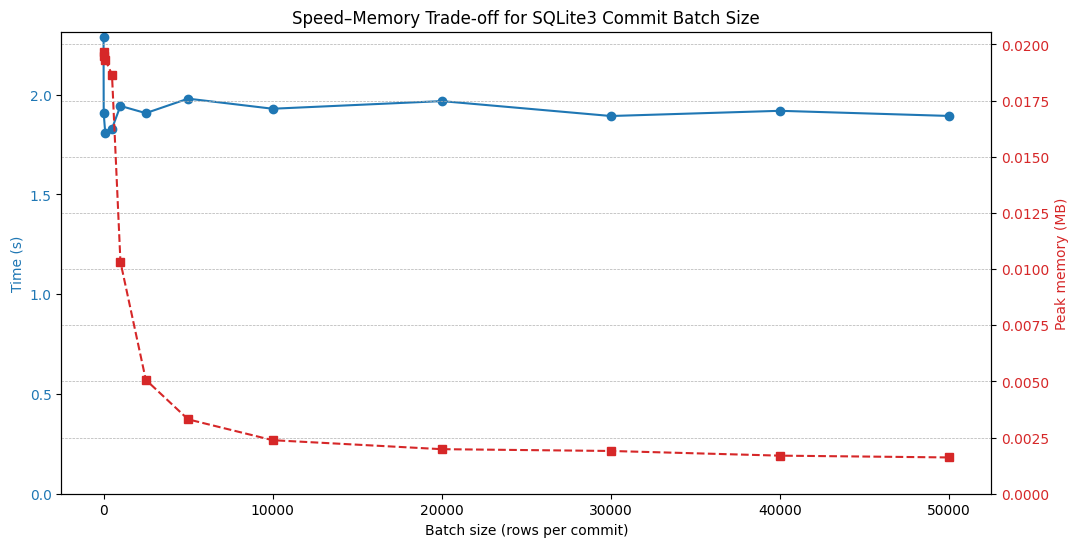

In [23]:
import matplotlib.pyplot as plt

# unpack your results
batch_sizes   = [r[0] for r in results]
median_times  = [r[1] for r in results]
median_memory = [r[2] / 1e6 for r in results]  # convert bytes → MB

# create figure and twin axes
fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()           # right-side y-axis shares the same x-axis

# left axis → time
ax1.plot(batch_sizes, median_times, "o-", color="tab:blue", label="Time (s)")
ax1.set_xlabel("Batch size (rows per commit)")
ax1.set_ylabel("Time (s)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# right axis → memory
ax2.plot(batch_sizes, median_memory, "s--", color="tab:red", label="Peak memory (MB)")
ax2.set_ylabel("Peak memory (MB)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)


plt.title("Speed–Memory Trade-off for SQLite3 Commit Batch Size")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

### Observations:
In the 1-to-100-file large batch-size we observe the majority of the amortization of SQL transaction overhead and in the 100 to 5000 files range is where we observe the lowest values of total op duration.
The peak memory profile tells a similar story, decreasing one order of magnitude when going from 1 file per commit to 20k, then plateuing observably.

## **Result**:
### Optimal batch size appears to be around 5-10k files per batch.
Five thousand will be used in the interest of keeping commits smaller for safety.
